In [1]:
import pandas as pd
import numpy as np

In [2]:
%run data_cleaning.ipynb
%run data_exploration.ipynb

Total number of rows:  11317
Total number of columns:  20


# (Data cleaning)

- Create a column for the booking date and convert to datetime (day_scrap, hour_scrap)

In [3]:
cur_time = datetime.datetime.now()
month = cur_time.strftime('%b')
year = cur_time.strftime('%Y')

In [4]:
dataset['date']=pd.to_datetime(dataset['day_scrap'].astype(str) + ' ' + month + ' ' + year + ' '+ dataset['hour_scrap'].astype(str), format='%d %b %Y %H')

- Bar chart
- Box plot
- Lineplot
- Heatmap

# Data visualization

## Setting-up

In [5]:
from plotnine import *
import matplotlib.pyplot as plt 
# import matplotlib.dates as mdates
# from mizani.formatters import percent_format
import seaborn as sns 
import datetime
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

- Outliers for ticket_price are removed from the dataset for data visualization, as it may significantly influence statistics.

In [6]:
dataset=dataset.loc[(dataset.ticket_price<6000)].reset_index(drop=True)

- Calculate total duration of round trip

In [7]:
dataset['tot_duration'] = (dataset["out_duration"] + dataset["in_duration"]).reset_index(drop=True)

In [8]:
nyc=dataset.loc[dataset.arr_city=='JFK'].reset_index(drop=True)
sao=dataset.loc[dataset.arr_city=='GRU'].reset_index(drop=True)

## Bar chart

#### a. Number of flights by destination and airline company

In [9]:
barplot = dataset.groupby(["arr_city", "out_airline_company"]).size().reset_index(name="N")
barplot["group_count"] = barplot.groupby("arr_city")["N"].transform("sum")
barplot['percent']=barplot['N']/barplot["group_count"]
barplot

,arr_city,out_airline_company,N,group_count,percent
0,GRU,Lufthansa,2923,5460,0.535348
1,GRU,Swiss,2537,5460,0.464652
2,JFK,Lufthansa,2808,5788,0.485142
3,JFK,Swiss,2980,5788,0.514858


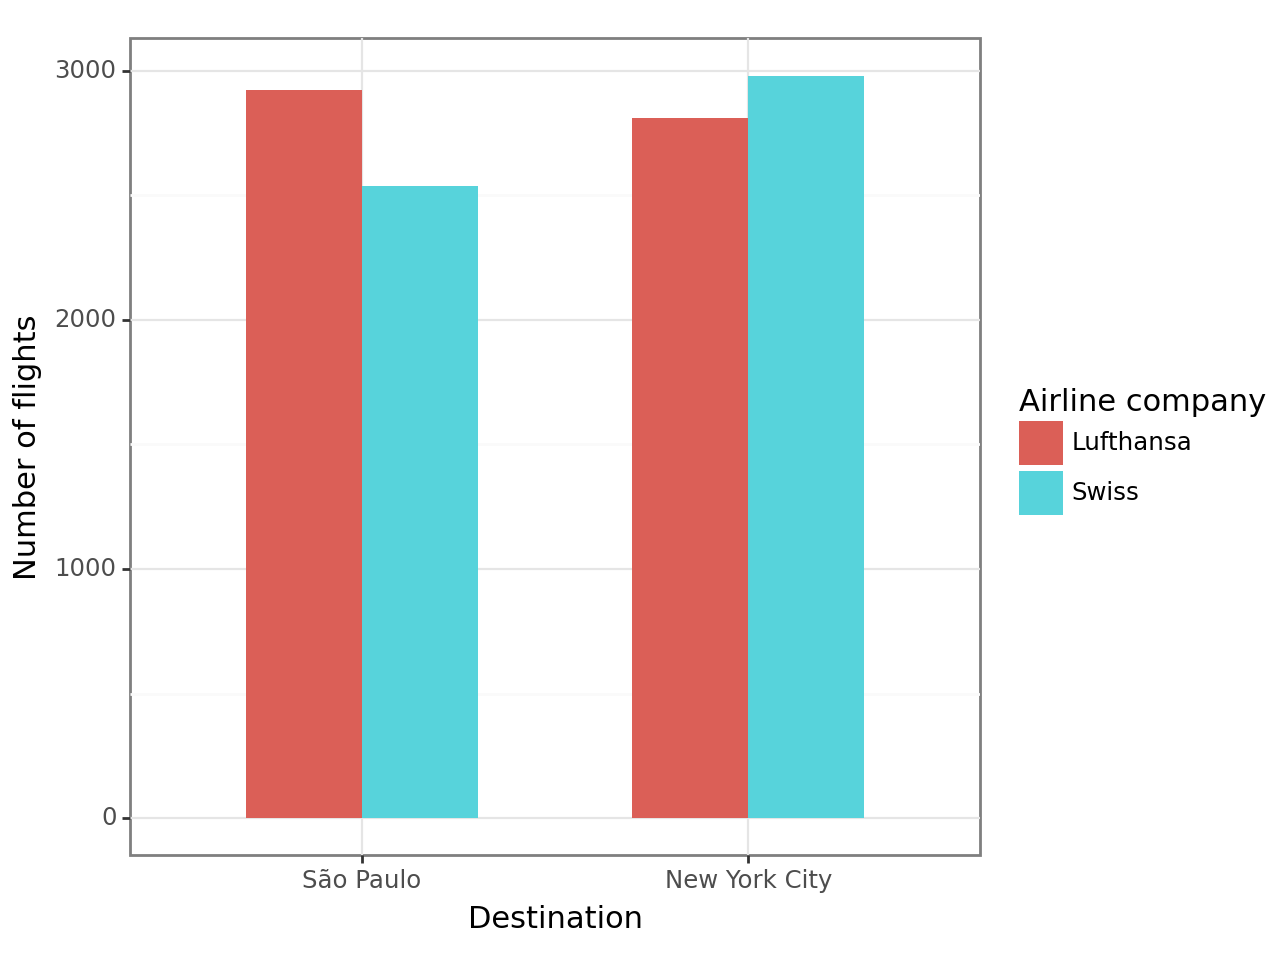

<Figure Size: (640 x 480)>

In [10]:
f1= (ggplot(barplot, aes(x="arr_city", y="N", fill="out_airline_company"))
+ geom_bar(stat="identity", position="dodge", width=0.6, size=0.5)
+ labs(x="Destination", y="Number of flights", fill="Airline company")
+ scale_x_discrete(labels=["São Paulo", "New York City"])
+ theme_bw()
)
f1

#### b. Minimum ticket prices based on the day of the week

In [11]:
def bar_chart(dataset):
    barplot=dataset.filter(['date','ticket_price','out_airline_company'])
    barplot['day_of_week'] = dataset['date'].dt.strftime('%A')
    
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    barplot['day_of_week'] = pd.Categorical(barplot['day_of_week'], categories=weekday_order, ordered=True)
    
    min_prices = barplot.groupby(['day_of_week','out_airline_company'])['ticket_price'].min().reset_index()
    
    f2=(ggplot(min_prices, aes(x='day_of_week', y="ticket_price", fill='out_airline_company'))
    + geom_bar(stat="identity", position="stack", width=0.8, size=0.9)
    + labs(x="Day of the week", y="Ticket price", fill="Airline")
    + scale_fill_discrete(labels=["Lufthansa", "Swiss"])
    + theme_bw()
    )
    print(f2)
    

From Brussels to New York City

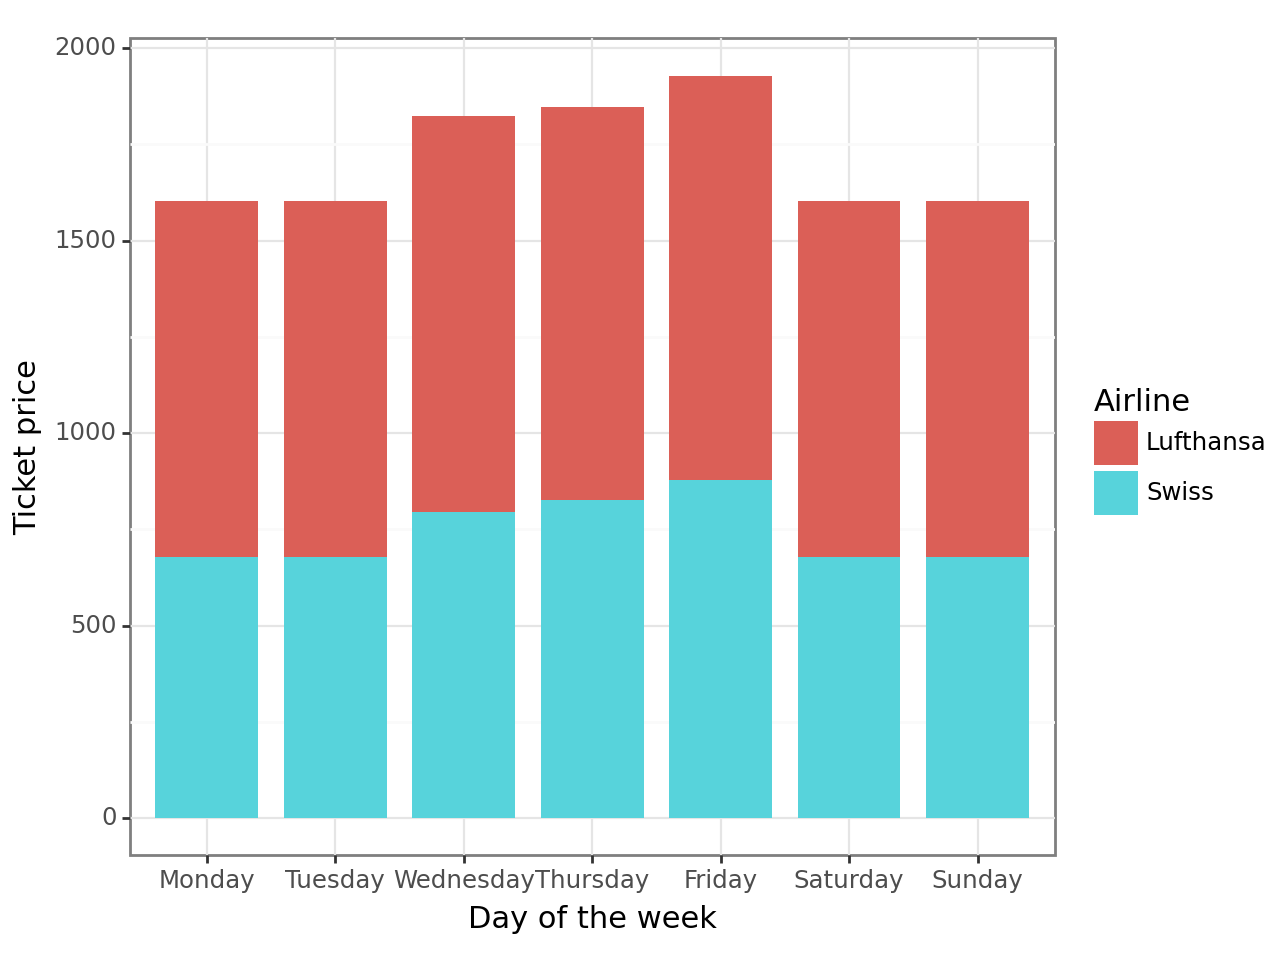

In [12]:
bar_chart(nyc)

From Brussels to Sao Paulo

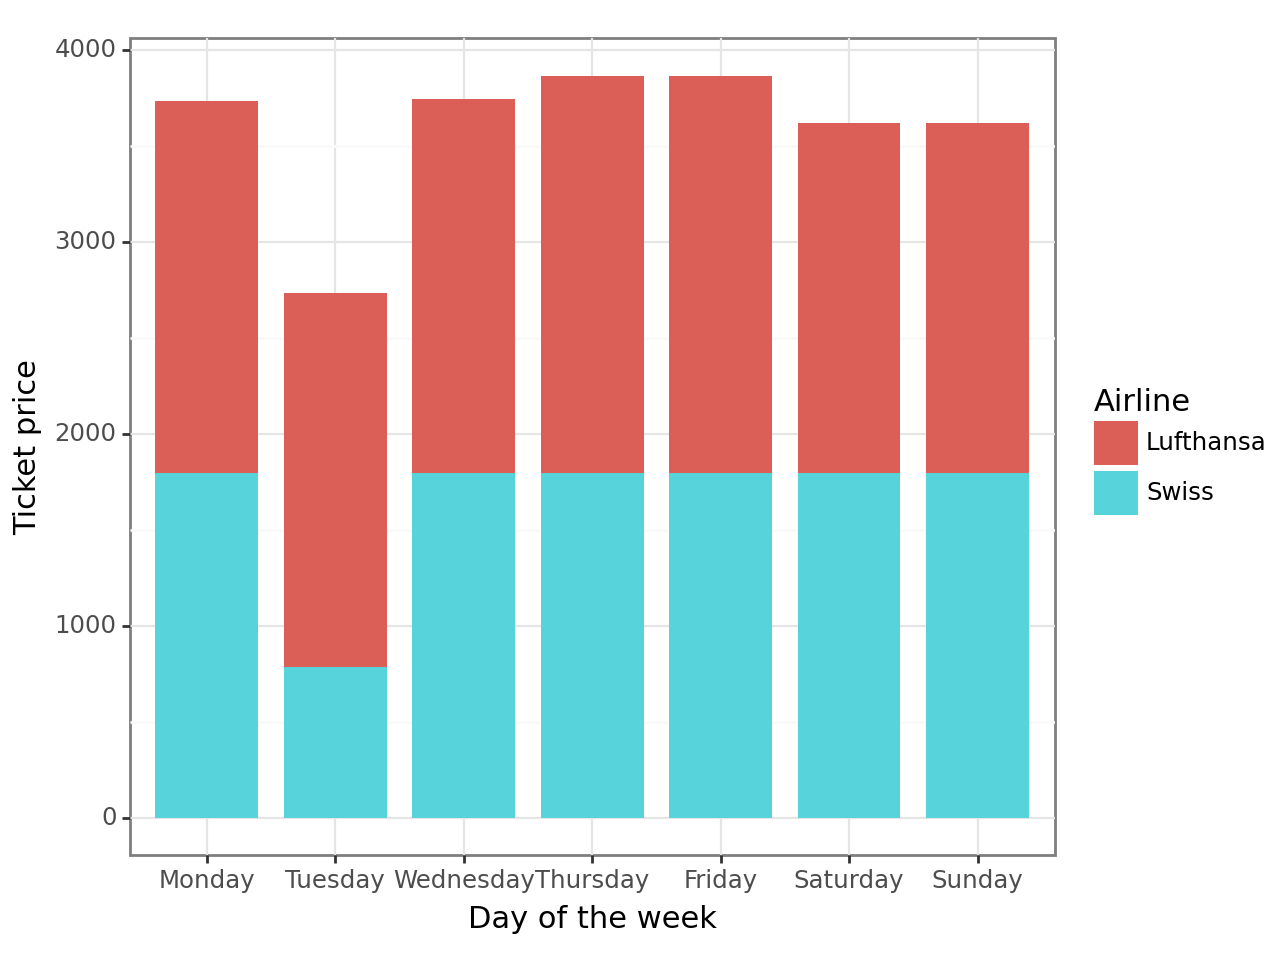

In [13]:
bar_chart(sao)

## Boxplot

In [14]:
lufthansa_nyc = nyc.loc[(nyc.out_airline_company == 'Lufthansa')]
swiss_nyc = nyc.loc[(nyc.out_airline_company == 'Swiss')]
lufthansa_sao = sao.loc[(sao.out_airline_company == 'Lufthansa')]
swiss_sao = sao.loc[(sao.out_airline_company == 'Swiss')]

In [15]:
def boxplot(dataset):
    f3 = (
    ggplot(dataset, aes(y='ticket_price', x='out_airline_company'))
    + geom_boxplot(color="blue", size=0.5, width=0.1, alpha=0.5)
    + labs(x="Cities", y="Prices")
    + theme_bw()
    )
    f3
    f3 = f3 + stat_boxplot(geom = "errorbar", width = 0.05,  size = 0.5, color = 'blue')
    f3

    print(f3 + stat_summary(fun_data="mean_se", geom="point", size=4, color="red", fill="red"))


From Brussels to New York City

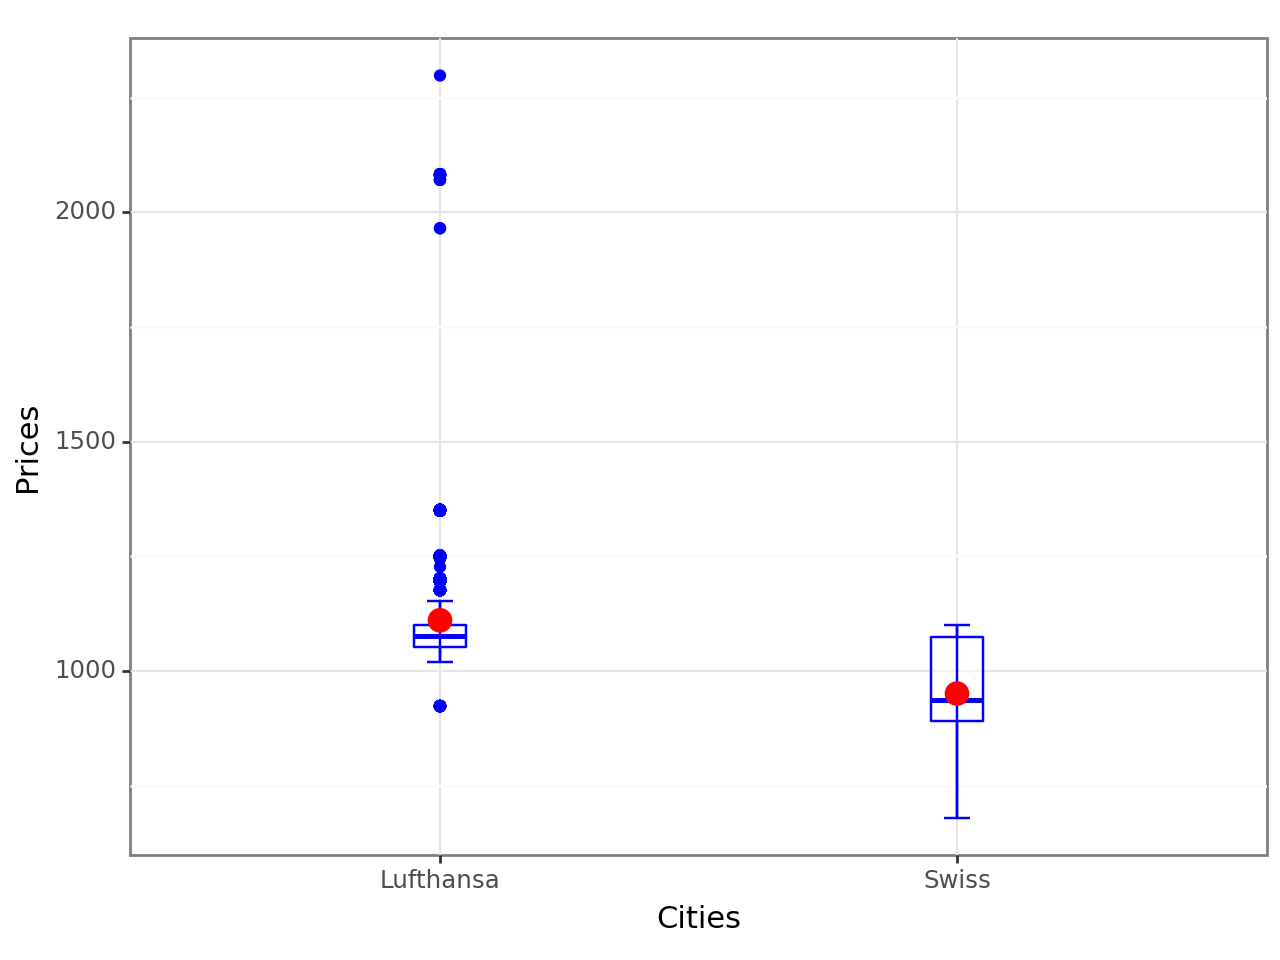

In [16]:
boxplot(nyc)

From Brussels to Sao Paulo

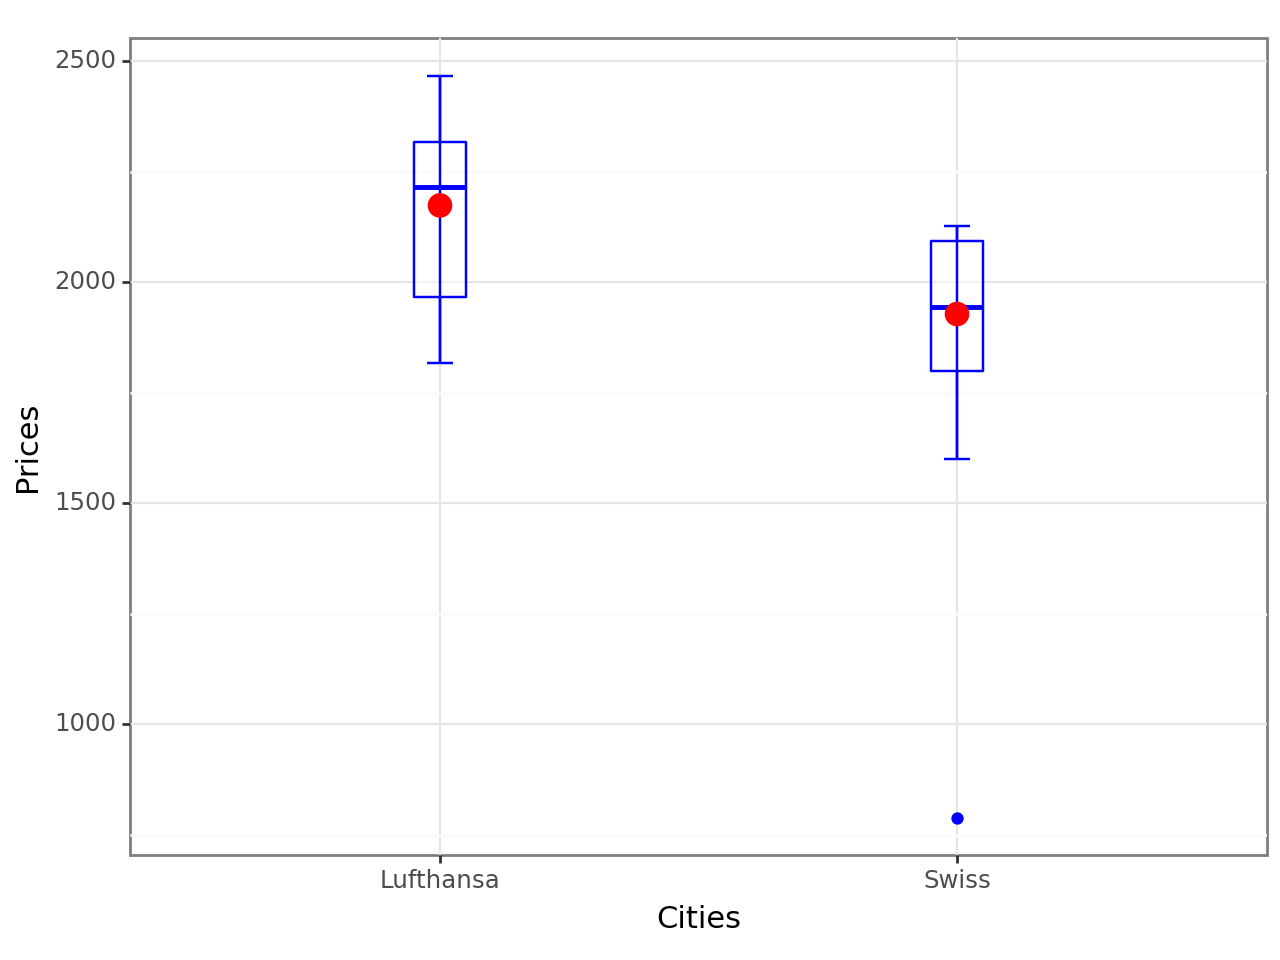

In [17]:
boxplot(sao)

## Lineplot

### a. Based on booking day

In [18]:
def lineplot_day(dataset):
    # booking day
    lineplot=dataset.filter(['date', 'arr_city','out_airline_company','ticket_price'])
    lineplot['day_booking']=lineplot['date'].dt.strftime('%d %b')

    # min price per day
    day_price=lineplot.groupby(['day_booking','out_airline_company'])['ticket_price'].min()
    day_price=day_price.reset_index()
    
    # transform to list
    date = day_price[day_price.out_airline_company=='Lufthansa']['day_booking'].tolist()
    price_lufthansa= day_price[day_price.out_airline_company == 'Lufthansa']['ticket_price'].tolist()
    price_swiss= day_price[day_price.out_airline_company == 'Swiss']['ticket_price'].tolist()
   
    # lineplot
    fig, ax1 = plt.subplots(figsize = (20,15))

    ax1.plot(date, price_lufthansa, "-s", color = 'k')
    plt.xticks(rotation=90)
    ax1.set_ylabel("Lufthansa price [€]", color = 'k')
    ax2 = ax1.twinx()
    ax2.plot(date, price_swiss,"-s",color = "royalblue")
    ax2.set_ylabel("Swiss price [€]", color = "royalblue")

    plt.xticks(rotation=90)
    plt.title('Flight (average) prices based on booking date');

- From Brussels to New York City

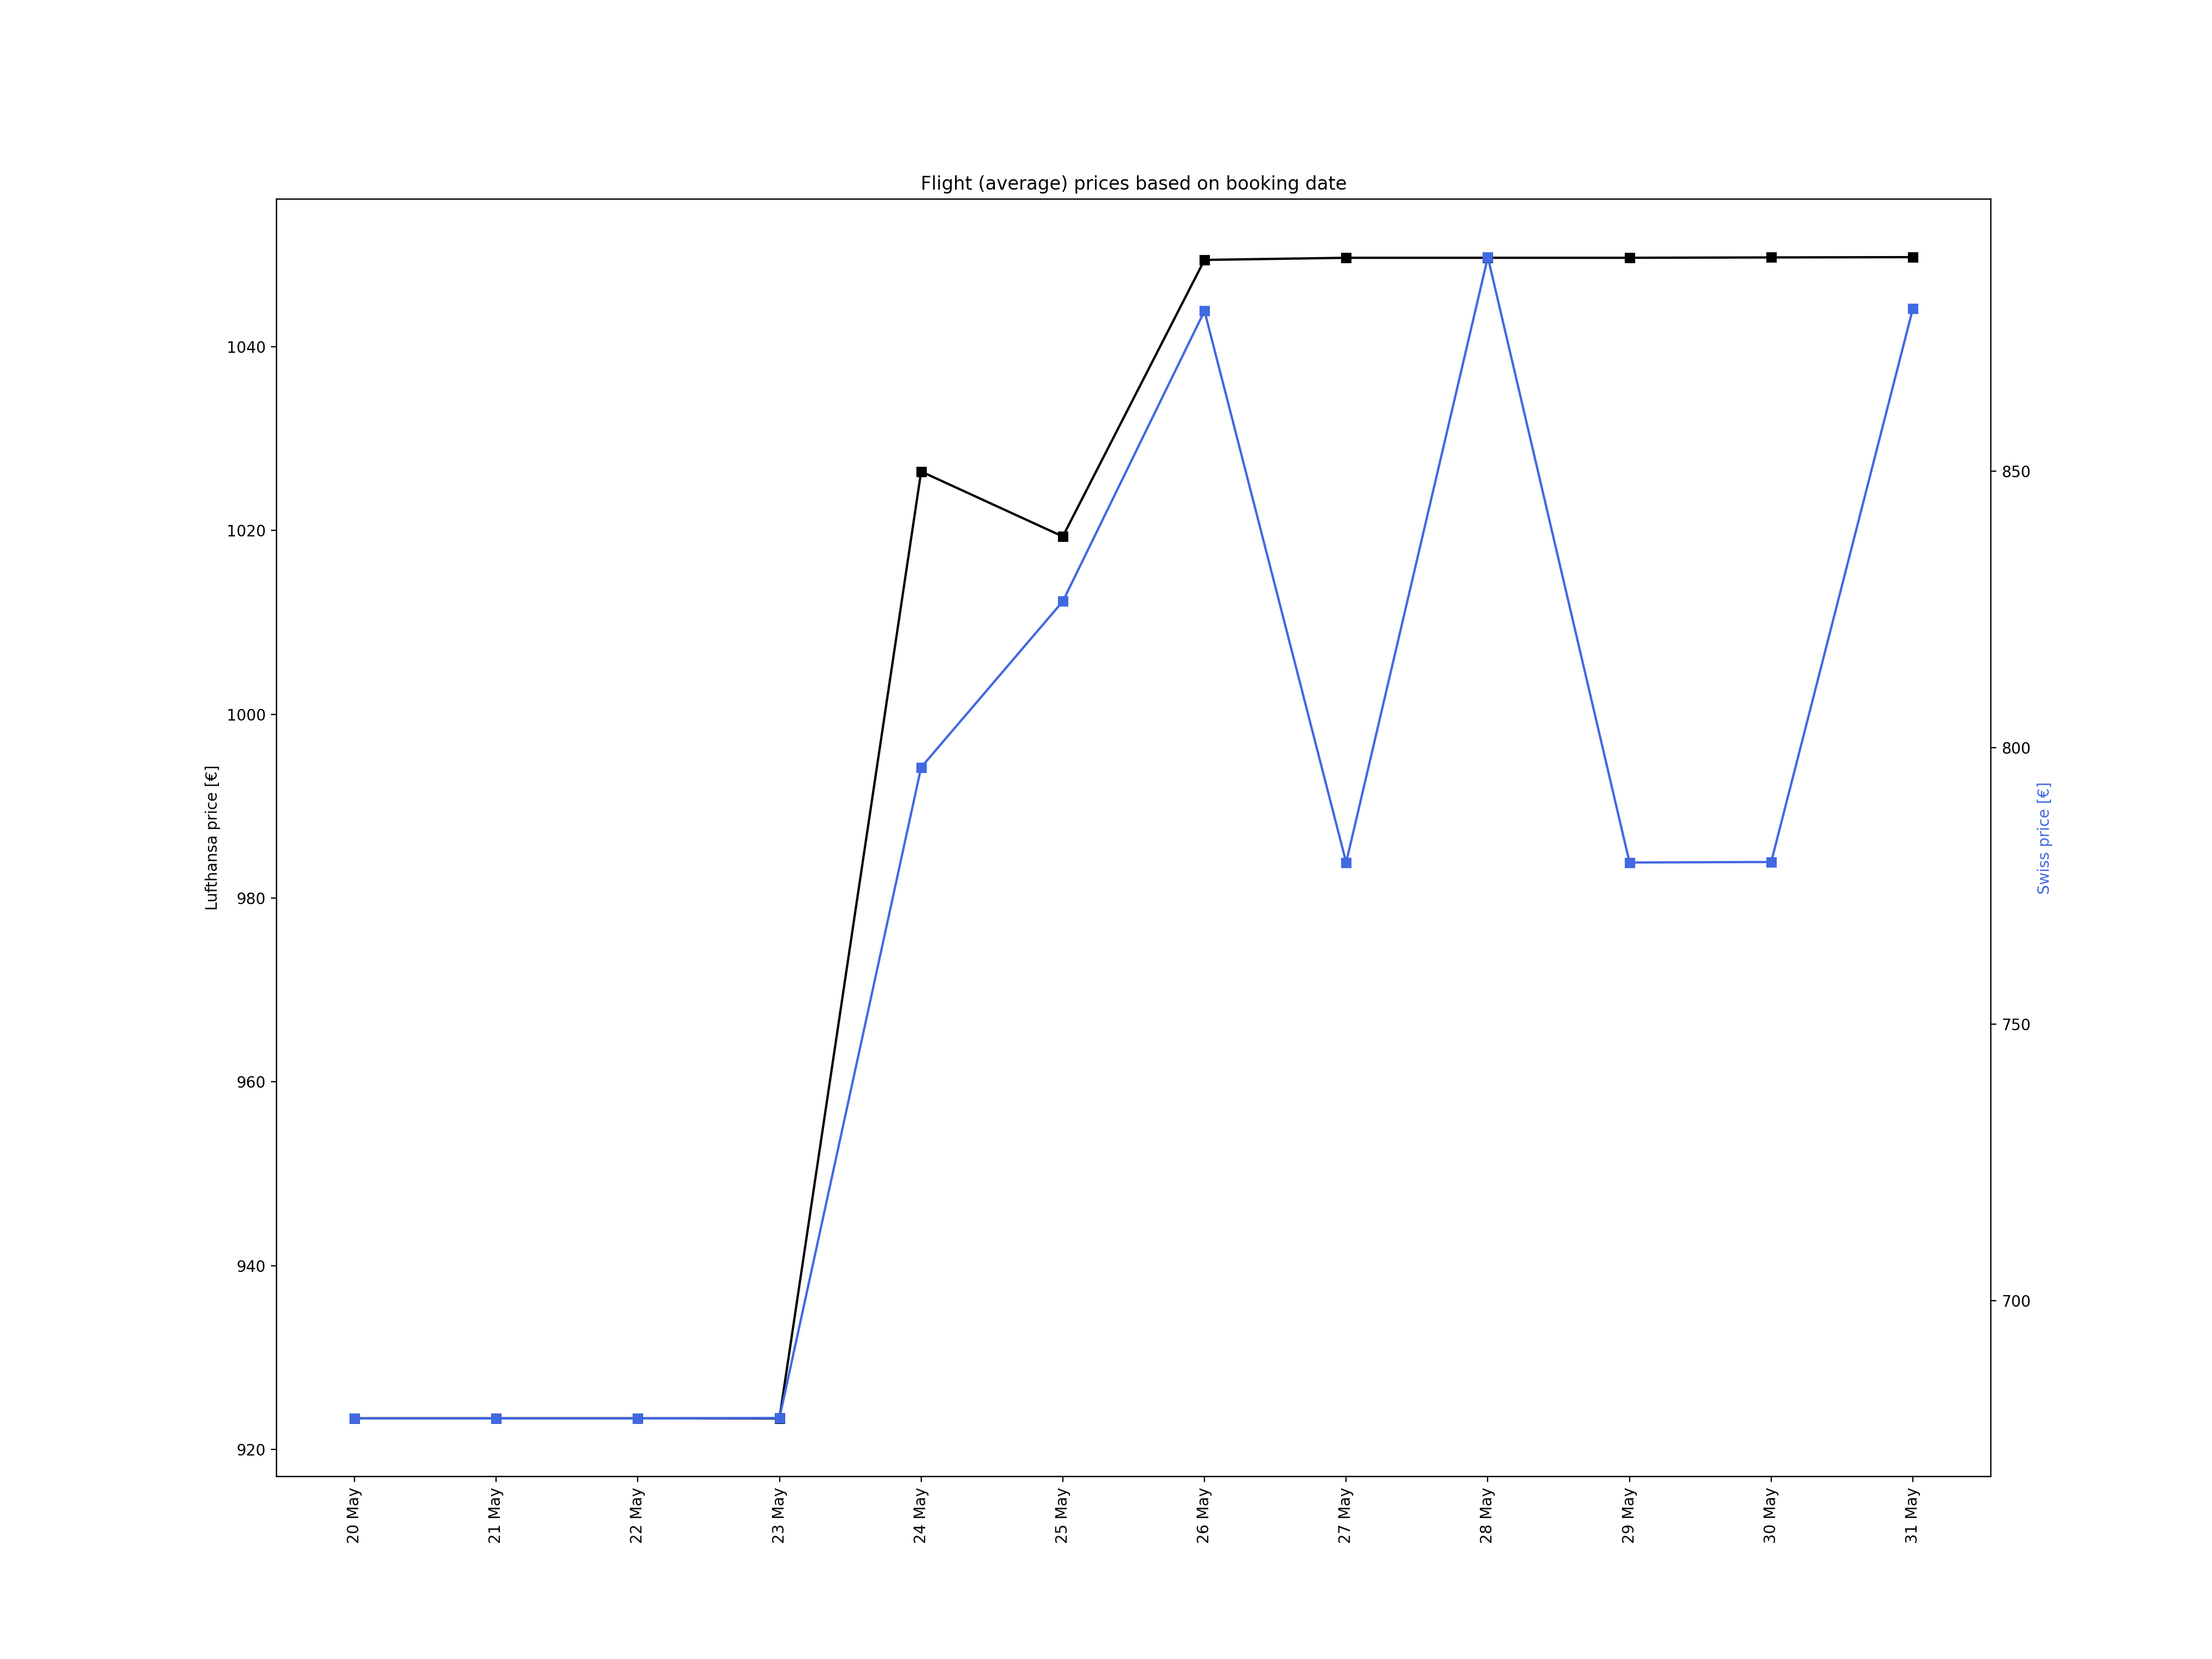

In [19]:
lineplot_day(dataset=nyc)

- From Brussels to Sao Paulo

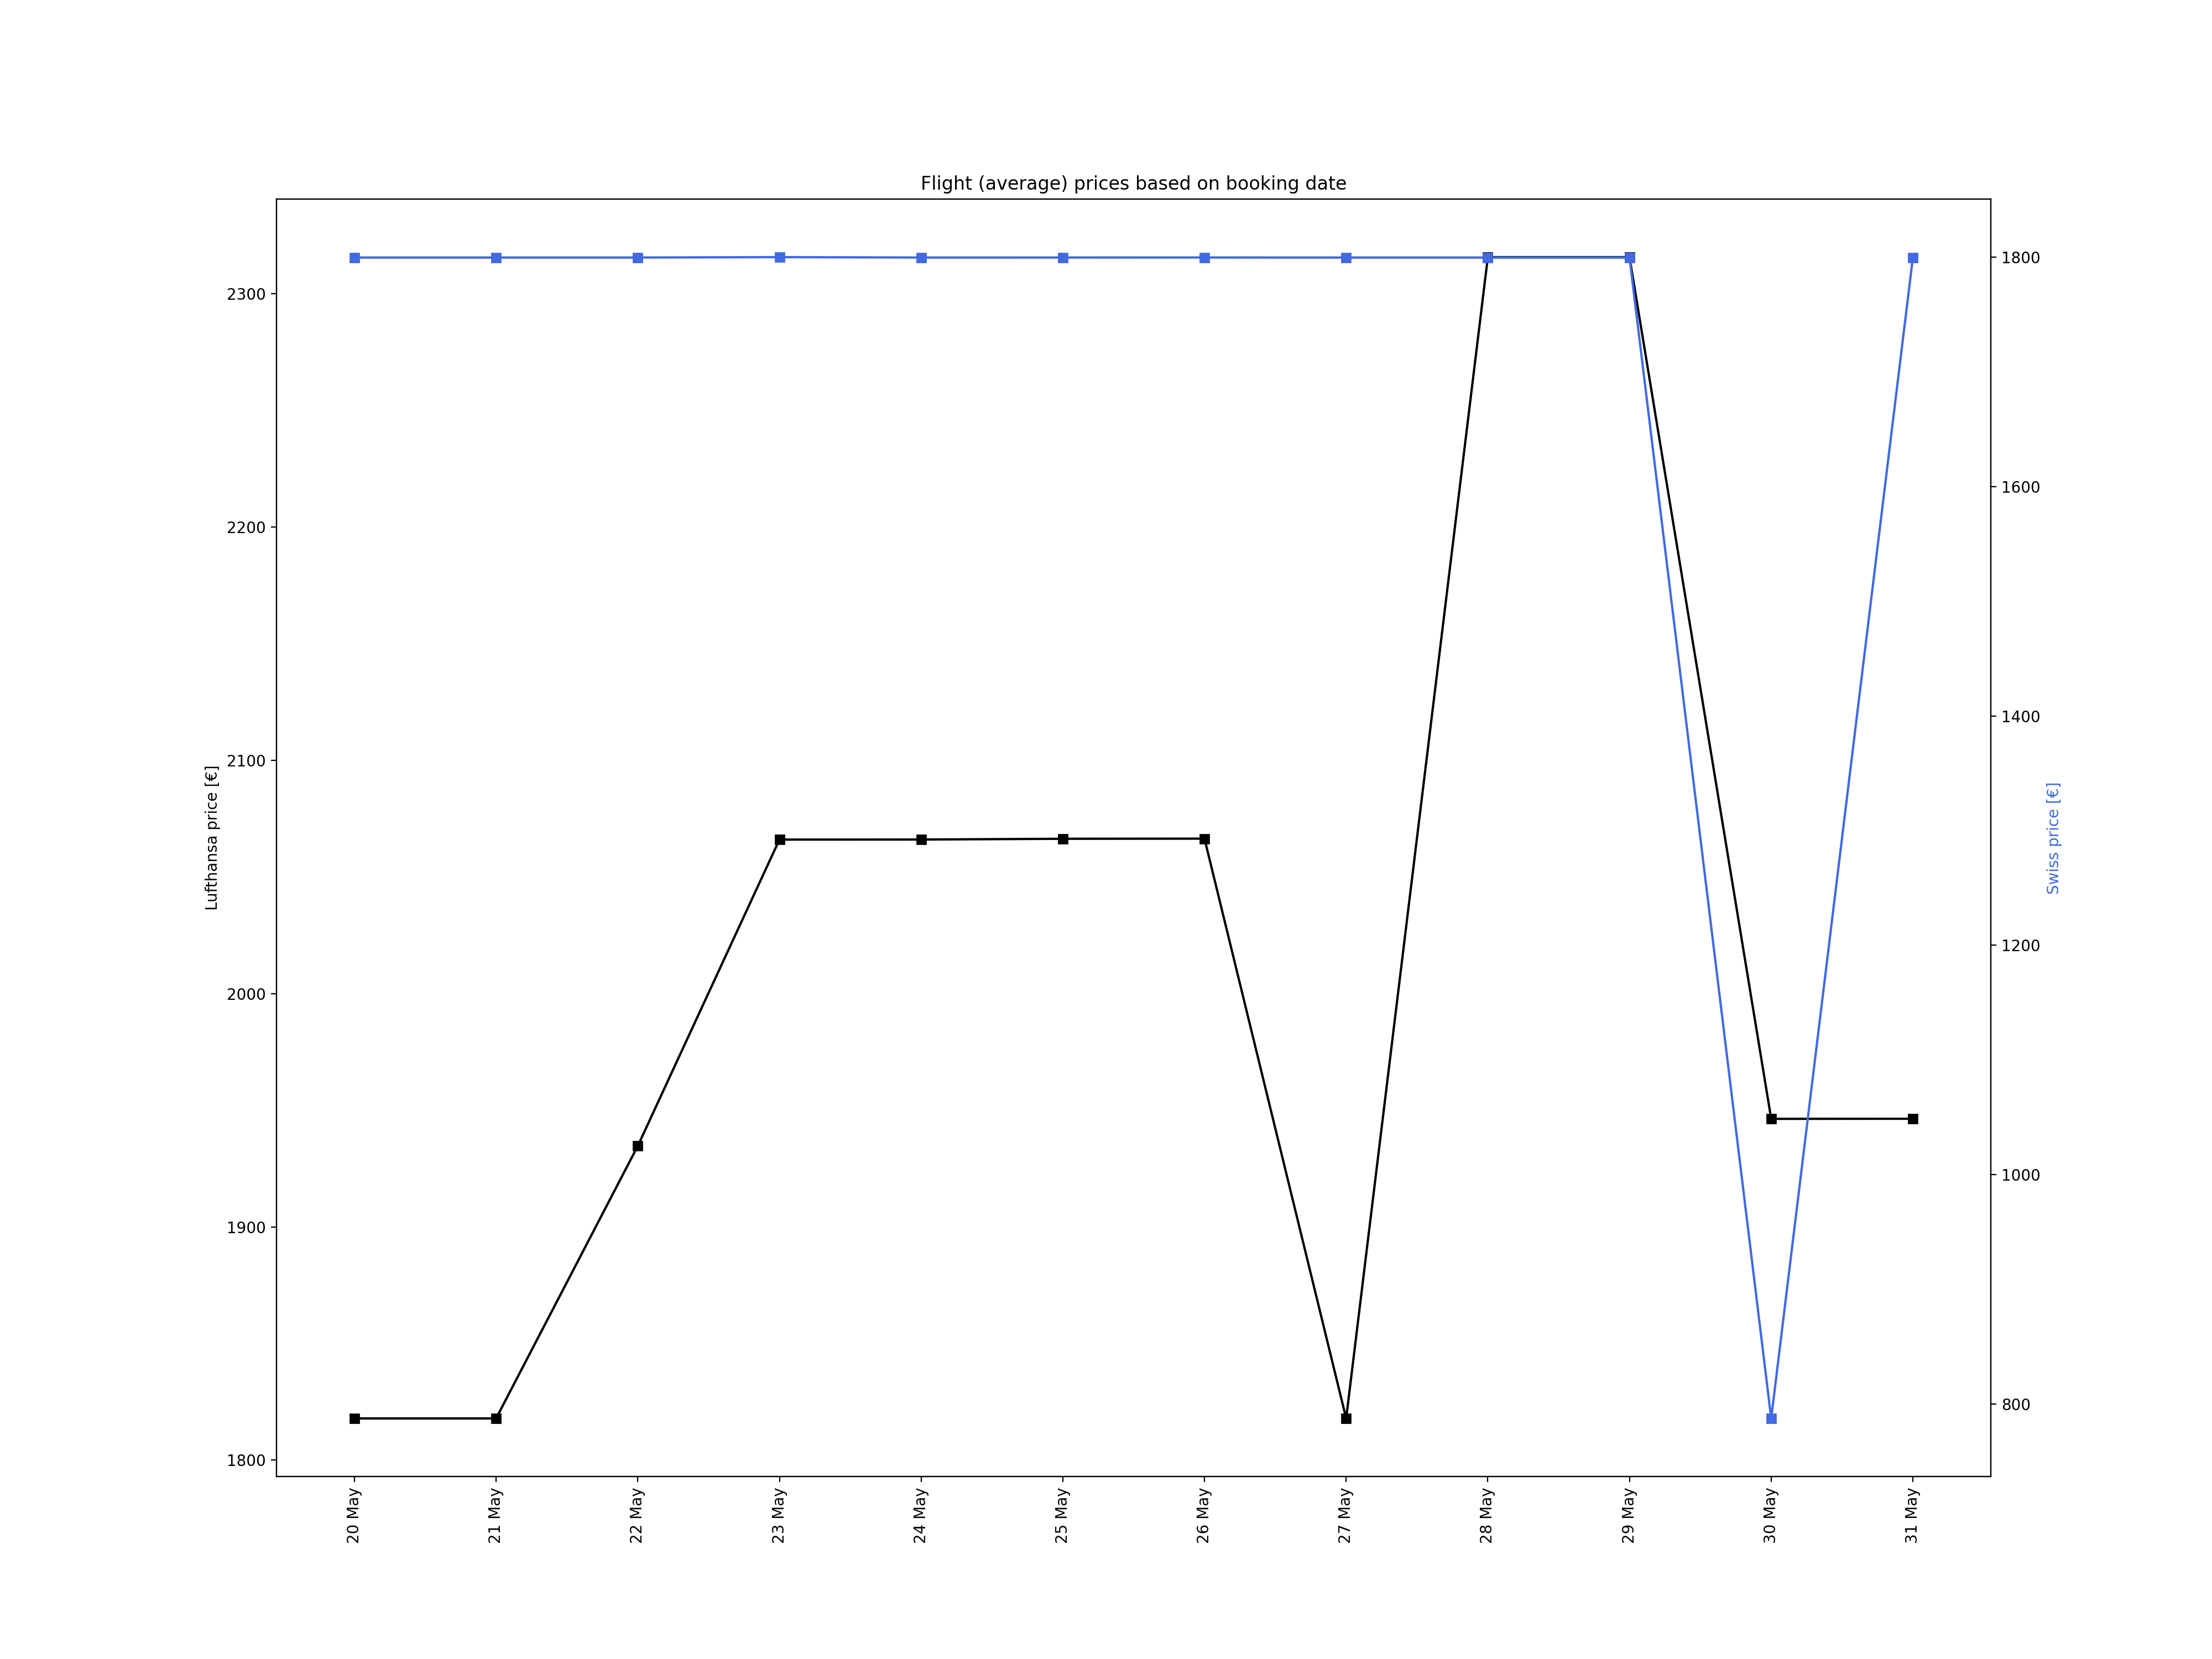

In [20]:
lineplot_day(dataset=sao)

### b. Based on booking time

In [21]:
def lineplot_time(dataset):
    lineplot = dataset.groupby(['out_airline_company','date'])['ticket_price'].agg(['min','mean','max'])
    lineplot = lineplot.reset_index()
    lineplot['date'] = lineplot['date'].dt.strftime('%d %b %I %p')

    date= lineplot[lineplot.out_airline_company == 'Lufthansa']['date'].tolist()
    price_lufthansa = lineplot[lineplot.out_airline_company == 'Lufthansa']['mean'].tolist()
    price_swiss = lineplot[lineplot.out_airline_company == 'Swiss']['mean'].tolist()

    # lineplot
    fig, ax1 = plt.subplots(figsize = (20,15))

    ax1.plot(date, price_lufthansa, color = 'k')
    plt.xticks(rotation=90)
    ax1.set_ylabel("Lufthansa price [€]", color = 'k')

    ax2 = ax1.twinx()
    ax2.plot(date, price_swiss, color = "royalblue")
    ax2.set_ylabel("Swiss price [€]", color = "royalblue")

    plt.xticks(rotation=90)
    plt.title('Flight (average) prices based on booking date');

From Brussels to New York City

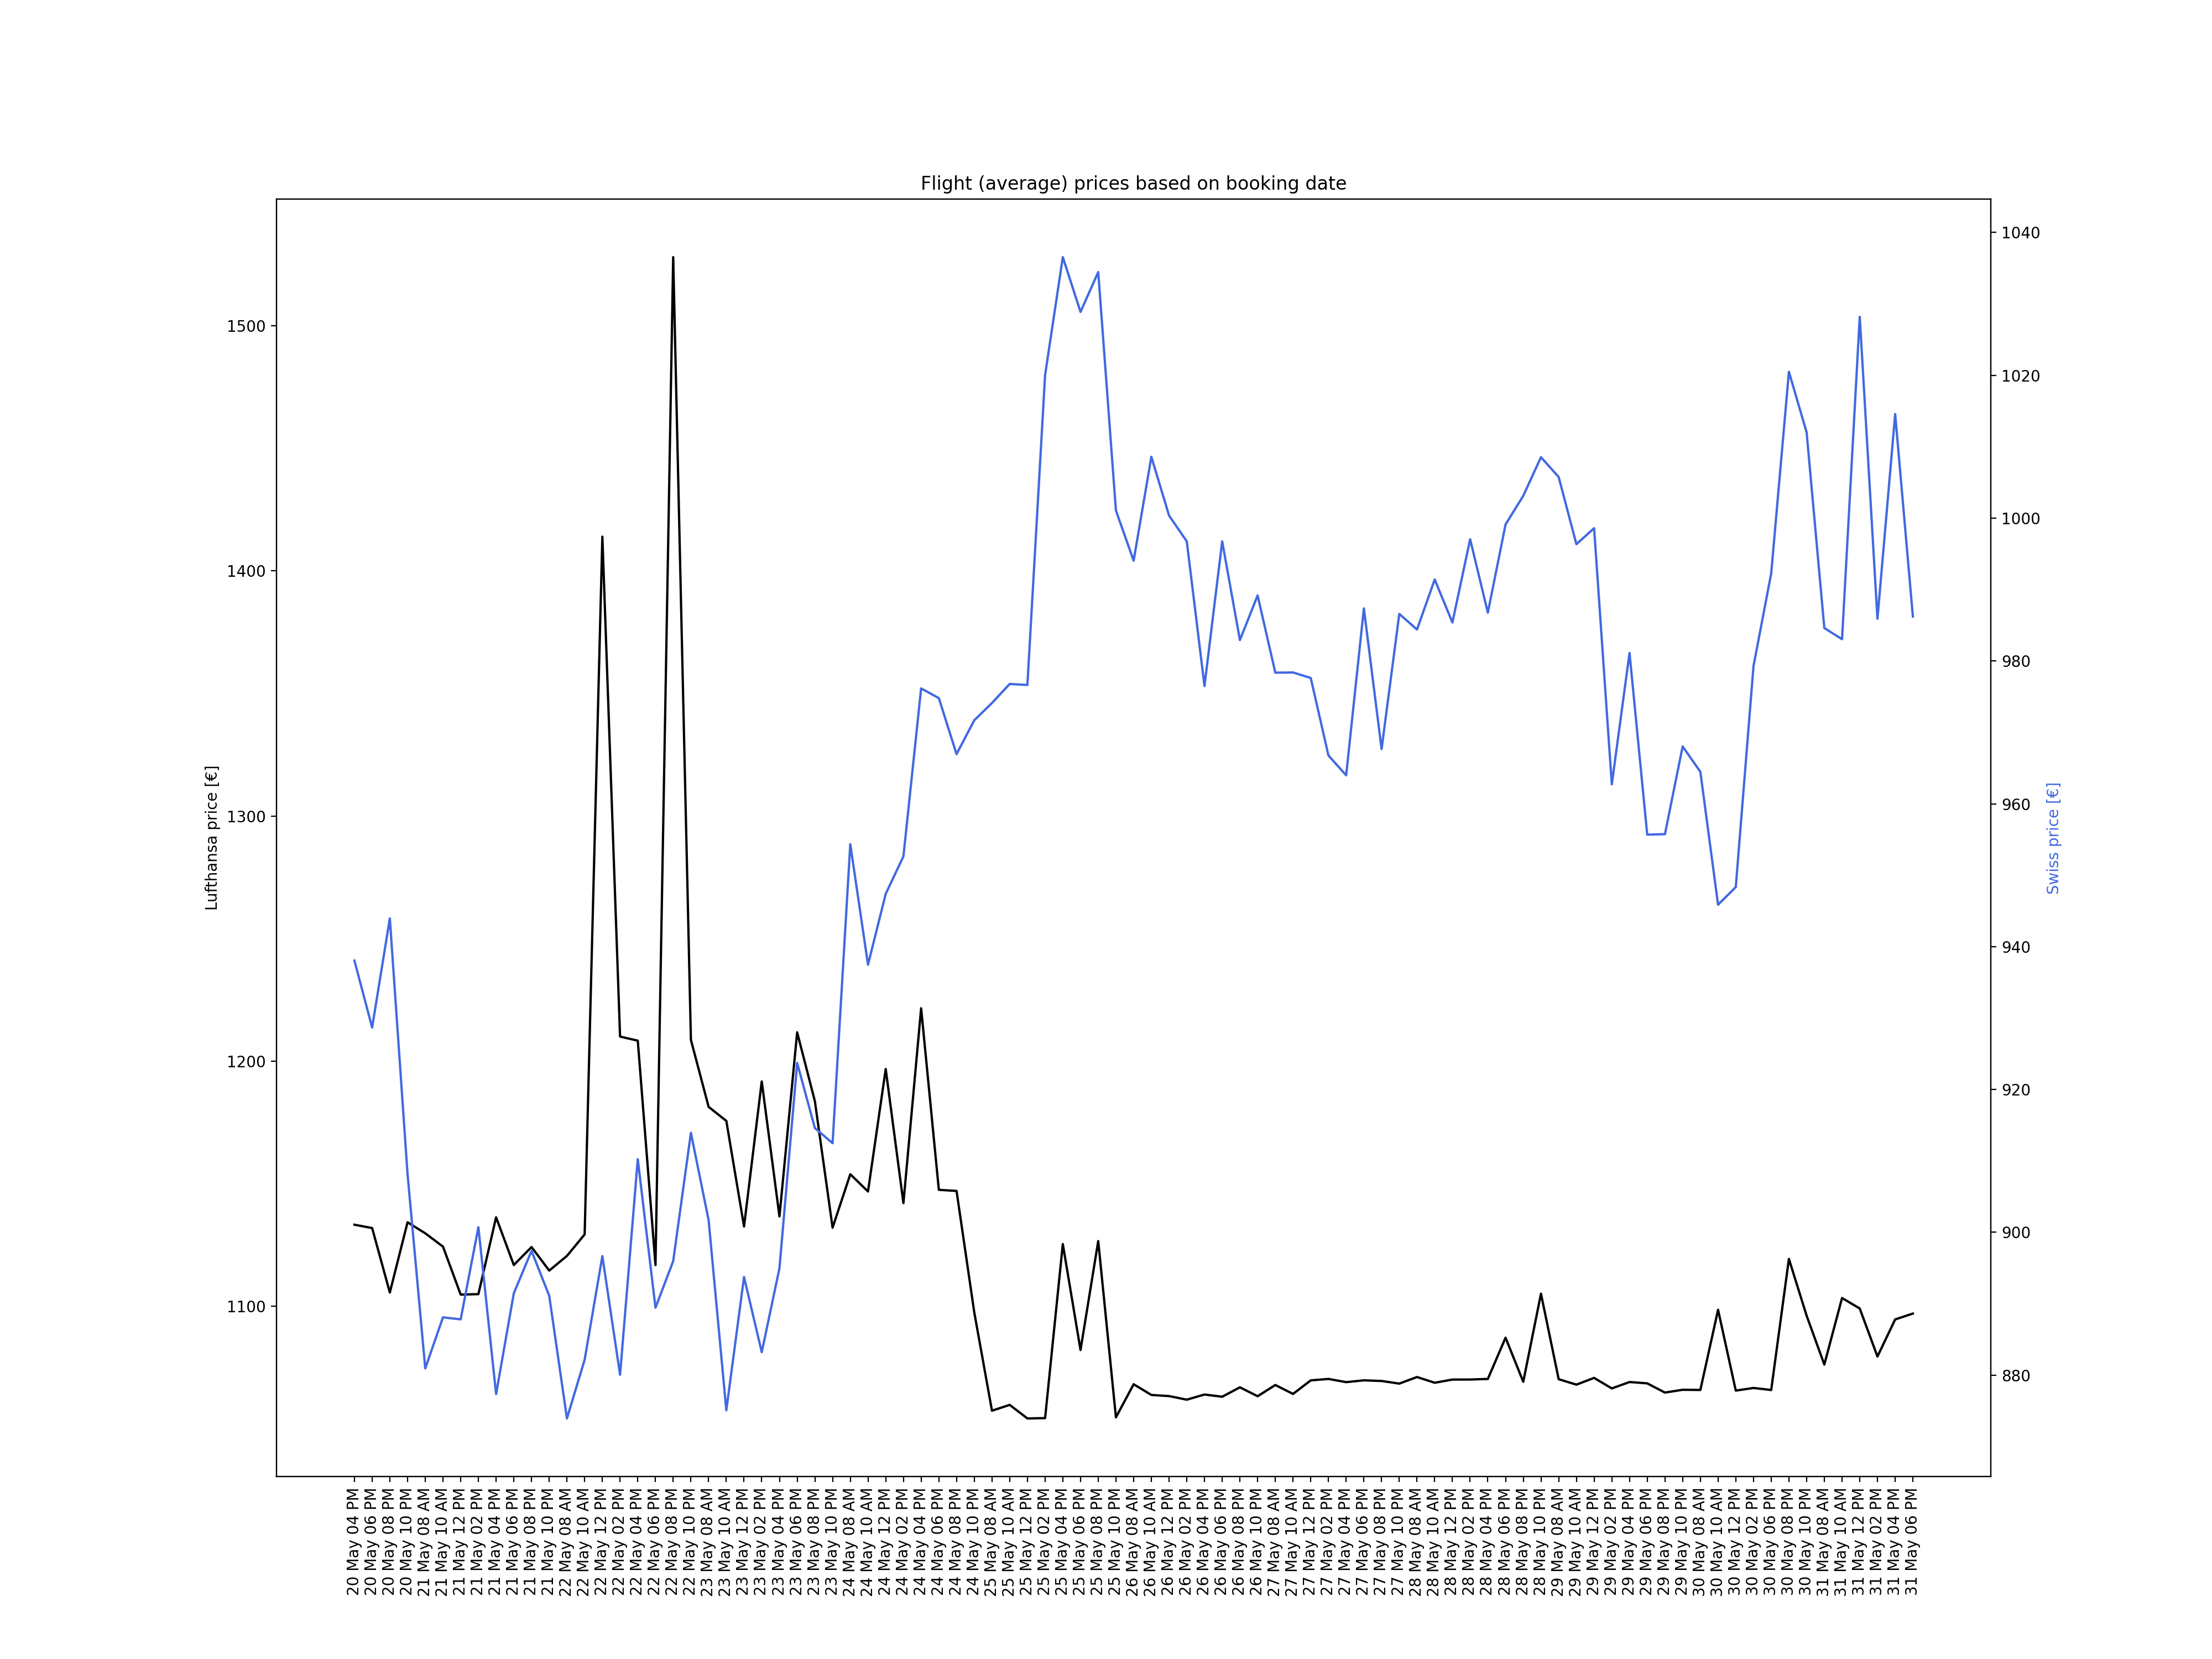

In [22]:
lineplot_time(dataset=nyc)

From Brussels to Sao Paulo

ValueError: x and y must have same first dimension, but have shapes (87,) and (89,)

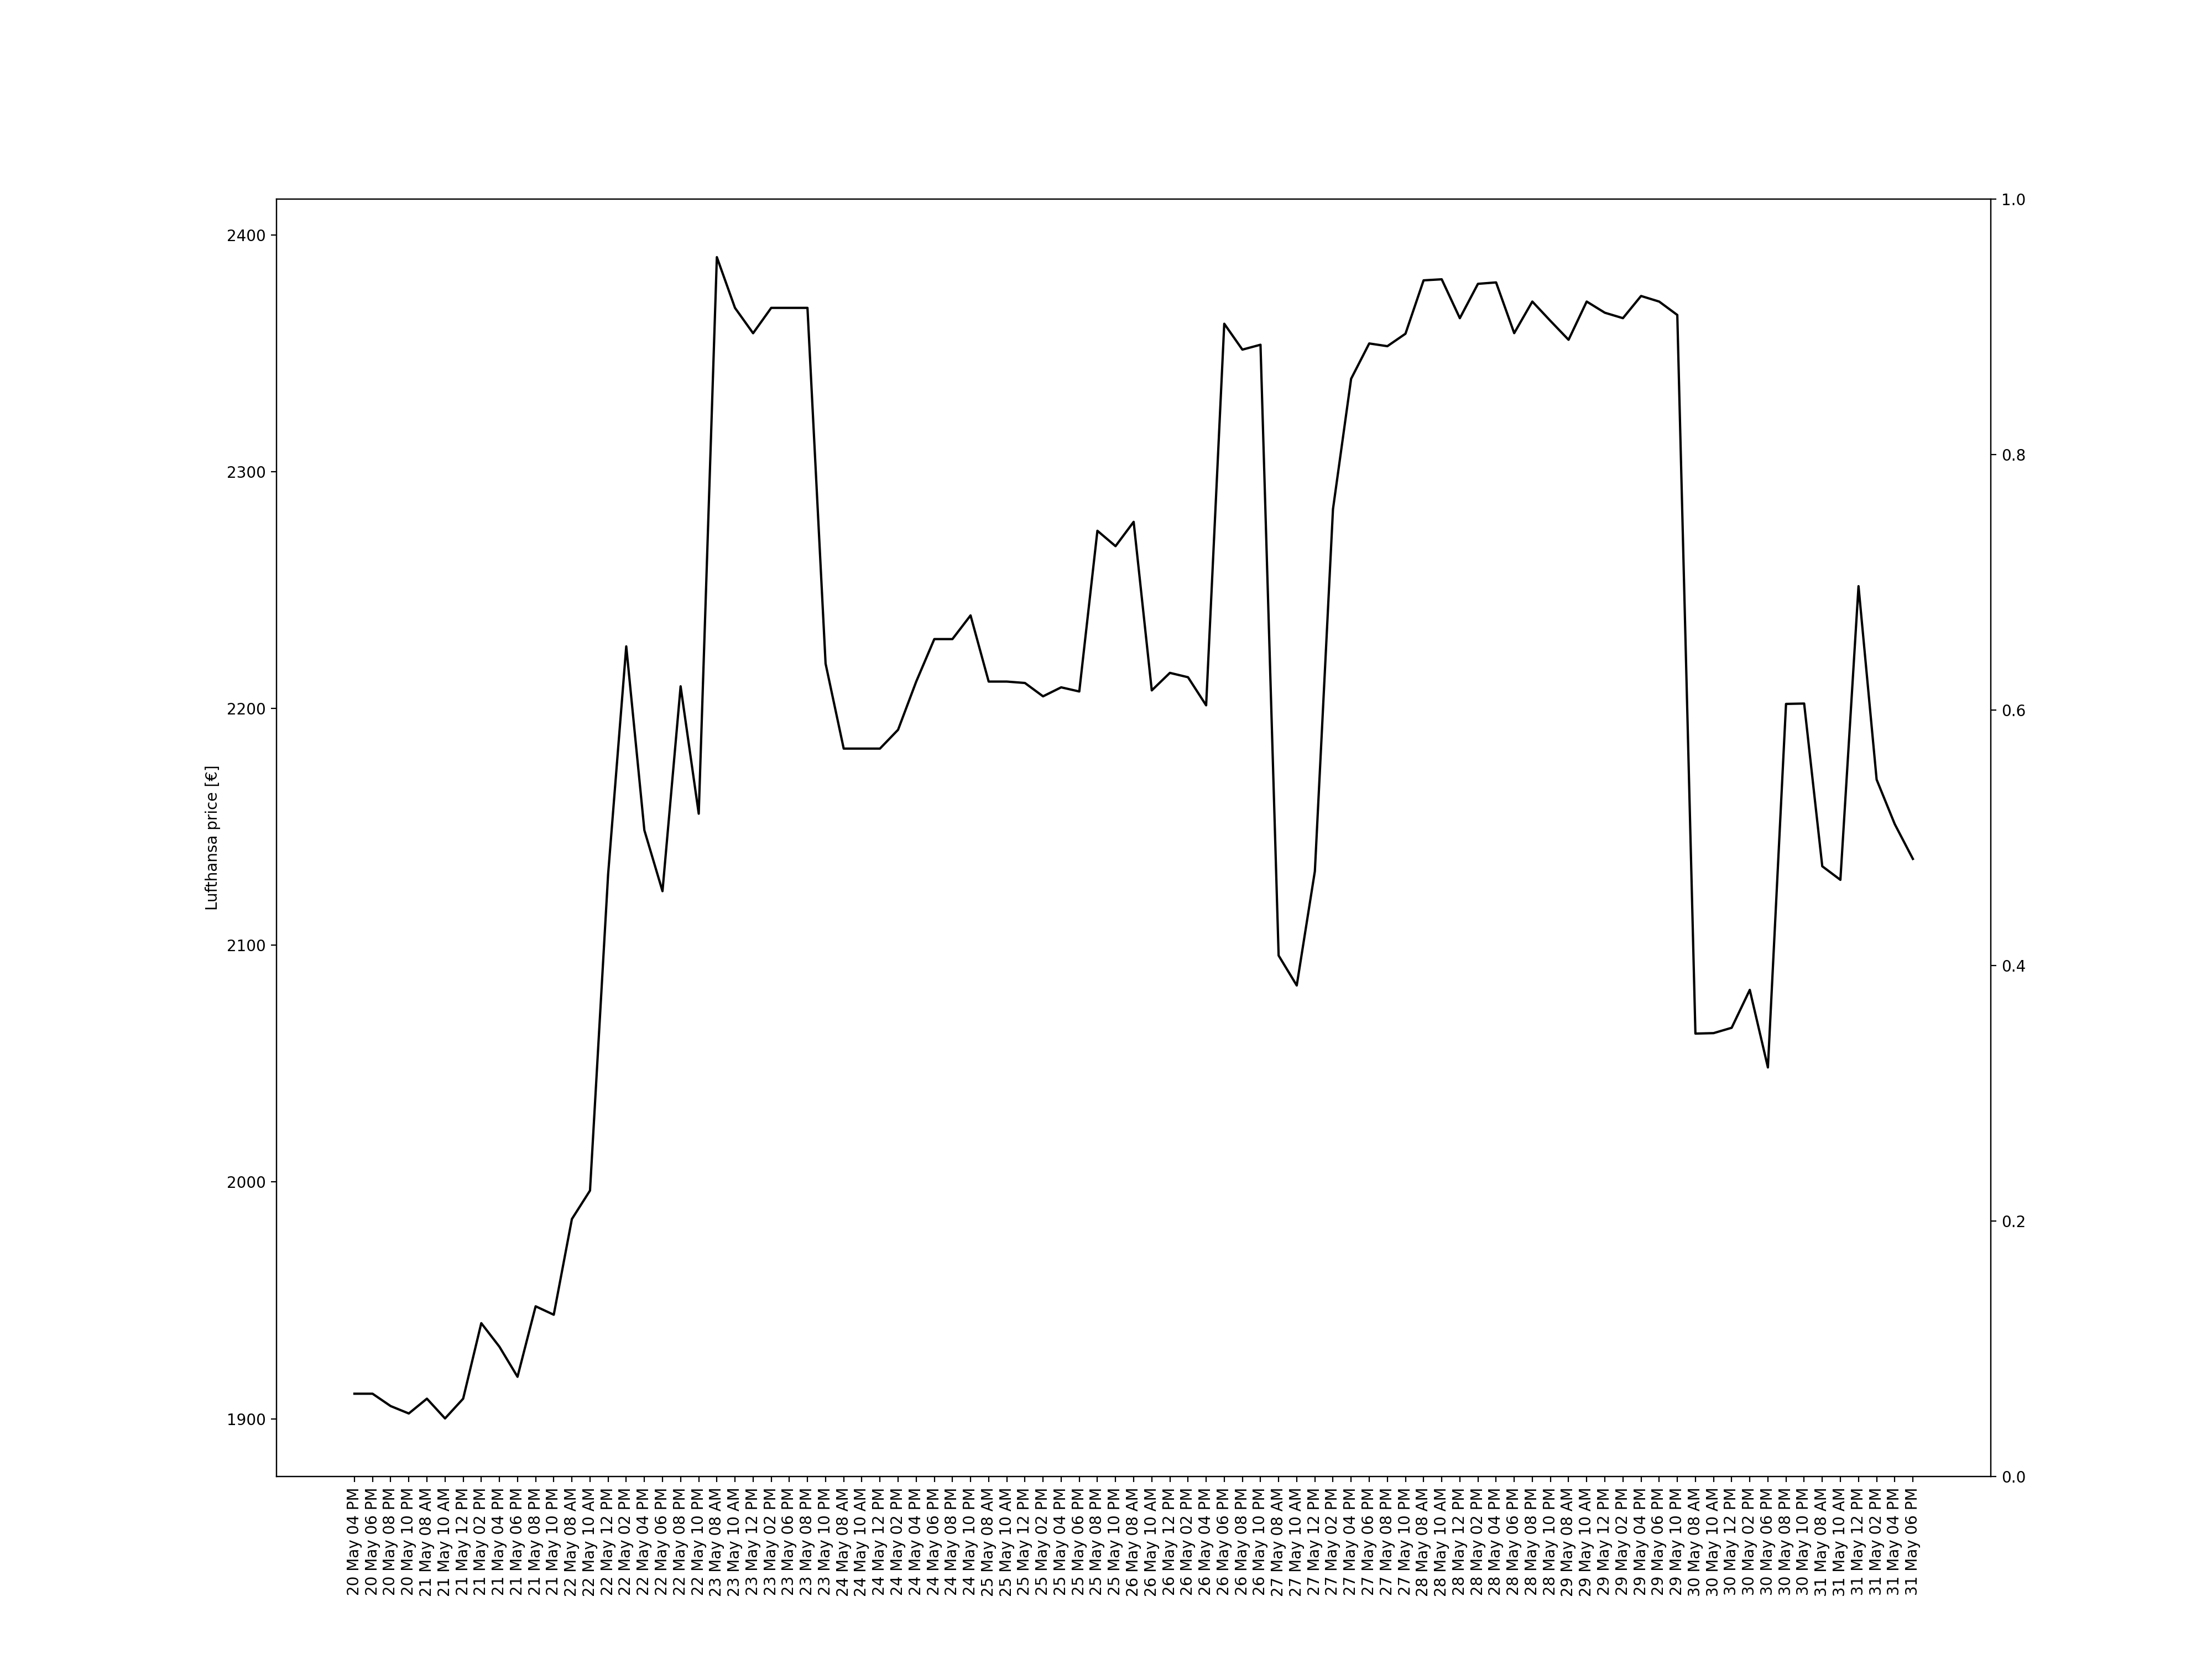

In [23]:
lineplot_time(dataset=sao)

### c. Price vs duration of flight

In [24]:
def duration_lineplot(dataset):
    plot_data = dataset[["ticket_price", "tot_duration", "out_airline_company"]]
    sns.lineplot(data=plot_data, x='tot_duration', y='ticket_price', hue='out_airline_company', estimator='mean')

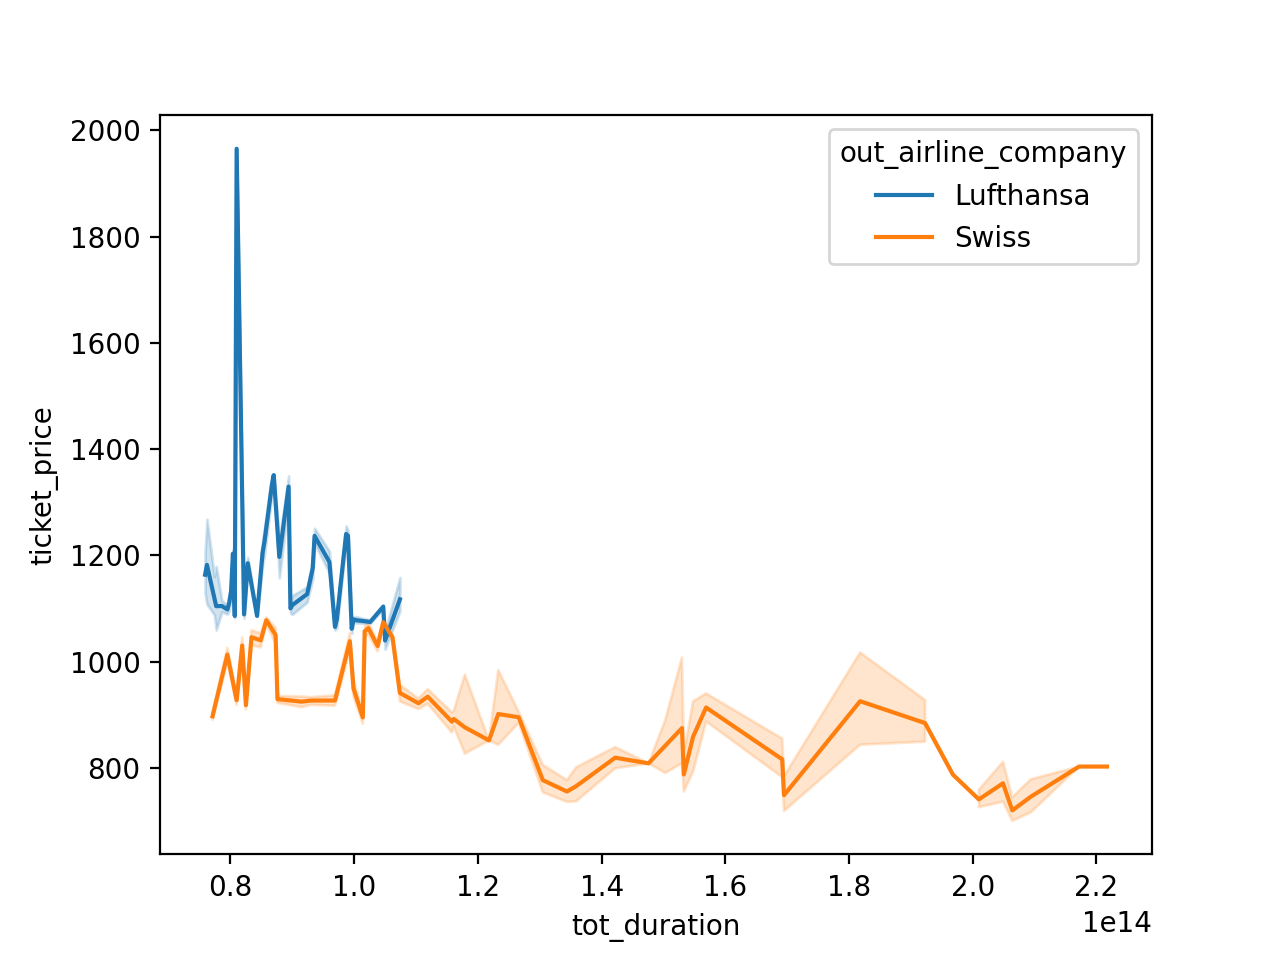

In [25]:
duration_lineplot(dataset=nyc)

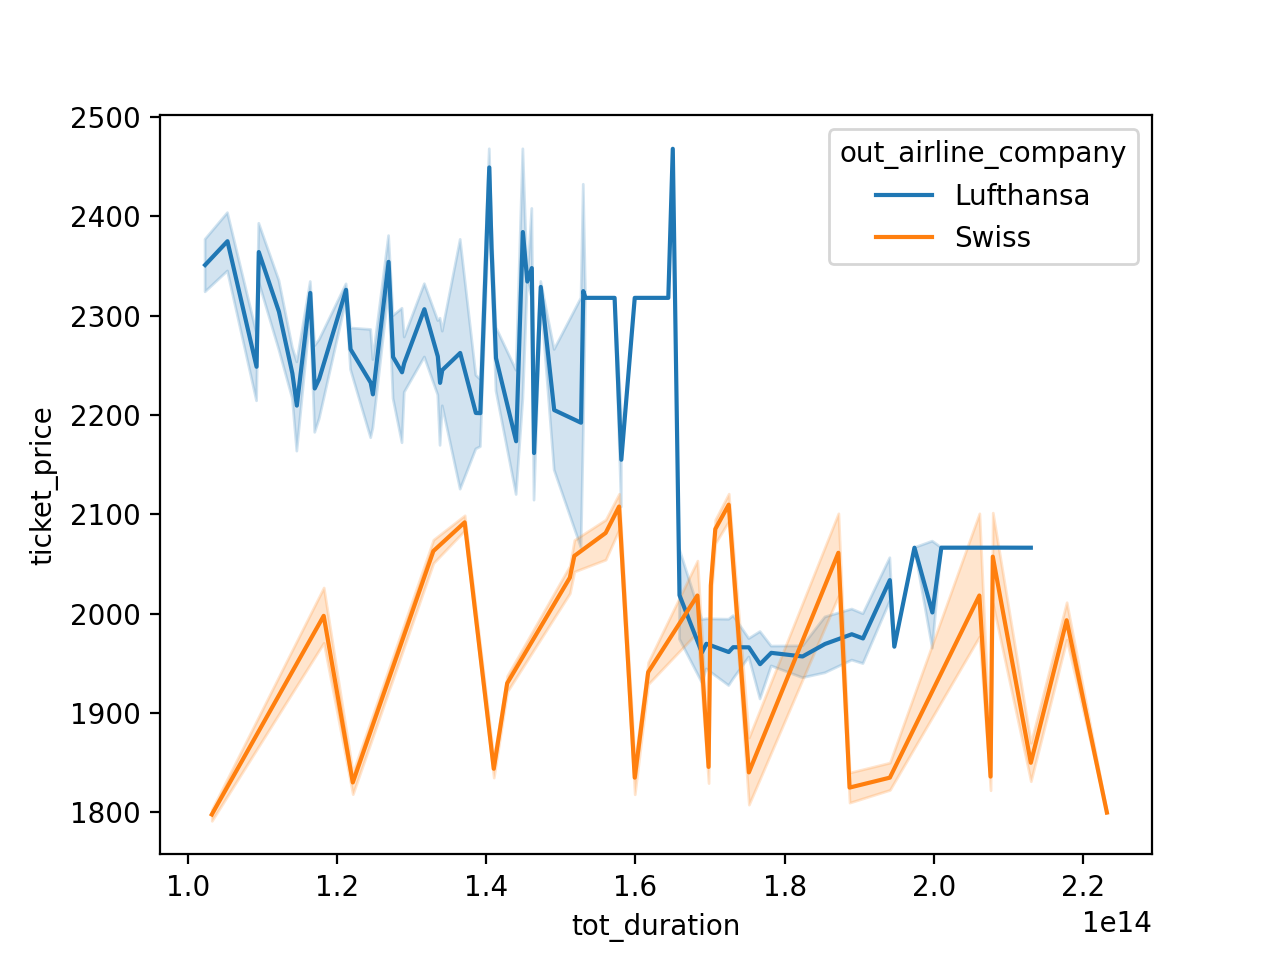

In [26]:
duration_lineplot(dataset=sao)

## Scatter plot

##### d1. scatter plot for New York City

In [27]:
scatterplot_nyc = dataset.loc[(dataset.arr_city=='JFK')].groupby(['out_airline_company','tot_duration'])['ticket_price'].mean().reset_index(name='price')
scatterplot_nyc

,out_airline_company,tot_duration,price
0,Lufthansa,0 days 21:05:00,1163.706144
1,Lufthansa,0 days 21:10:00,1182.182766
2,Lufthansa,0 days 21:30:00,1119.601579
3,Lufthansa,0 days 21:35:00,1104.440000
4,Lufthansa,0 days 21:50:00,1104.873846
...,...,...,...
83,Swiss,2 days 08:55:00,771.168750
84,Swiss,2 days 09:20:00,720.120000
85,Swiss,2 days 10:10:00,745.962143
86,Swiss,2 days 12:20:00,802.640000


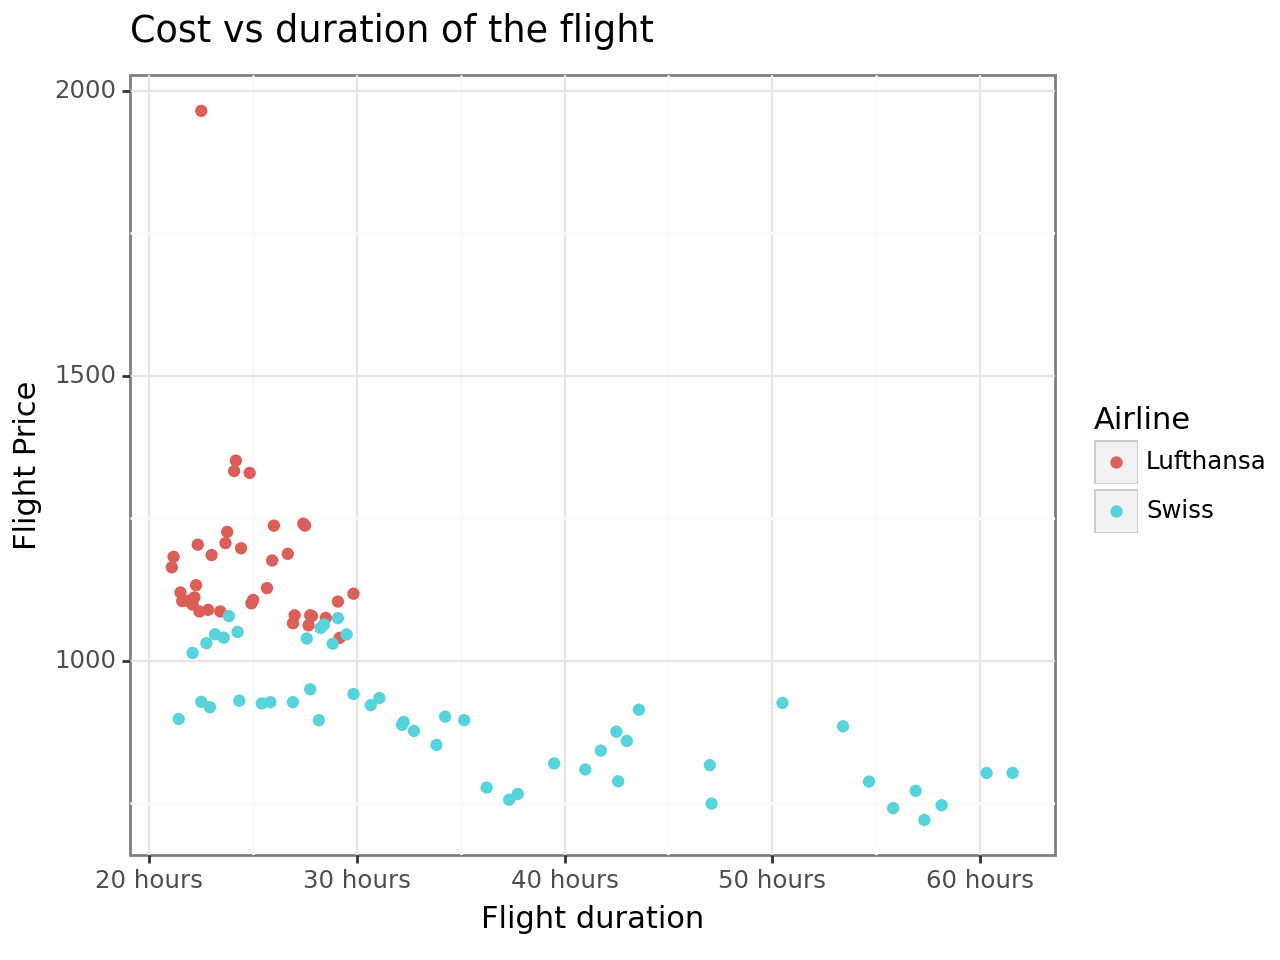

<Figure Size: (640 x 480)>

In [28]:
f6= (ggplot(scatterplot_nyc, aes(x='tot_duration', y='price', color='out_airline_company')) + \
    geom_point() + \
    labs(title='Cost vs duration of the flight',
         x='Flight duration',
         y='Flight Price',
         color='Airline') + \
    theme_bw()
)
f6

##### d2. scatter plot for São Paulo

In [29]:
scatterplot_sao = dataset.loc[(dataset.arr_city=='GRU')].groupby(['out_airline_company','tot_duration'])['ticket_price'].mean().reset_index(name='price')
scatterplot_sao.head()

,out_airline_company,tot_duration,price
0,Lufthansa,1 days 04:25:00,2350.832529
1,Lufthansa,1 days 05:15:00,2374.754138
2,Lufthansa,1 days 06:20:00,2248.436600
3,Lufthansa,1 days 06:25:00,2363.870000
4,Lufthansa,1 days 07:10:00,2303.866111


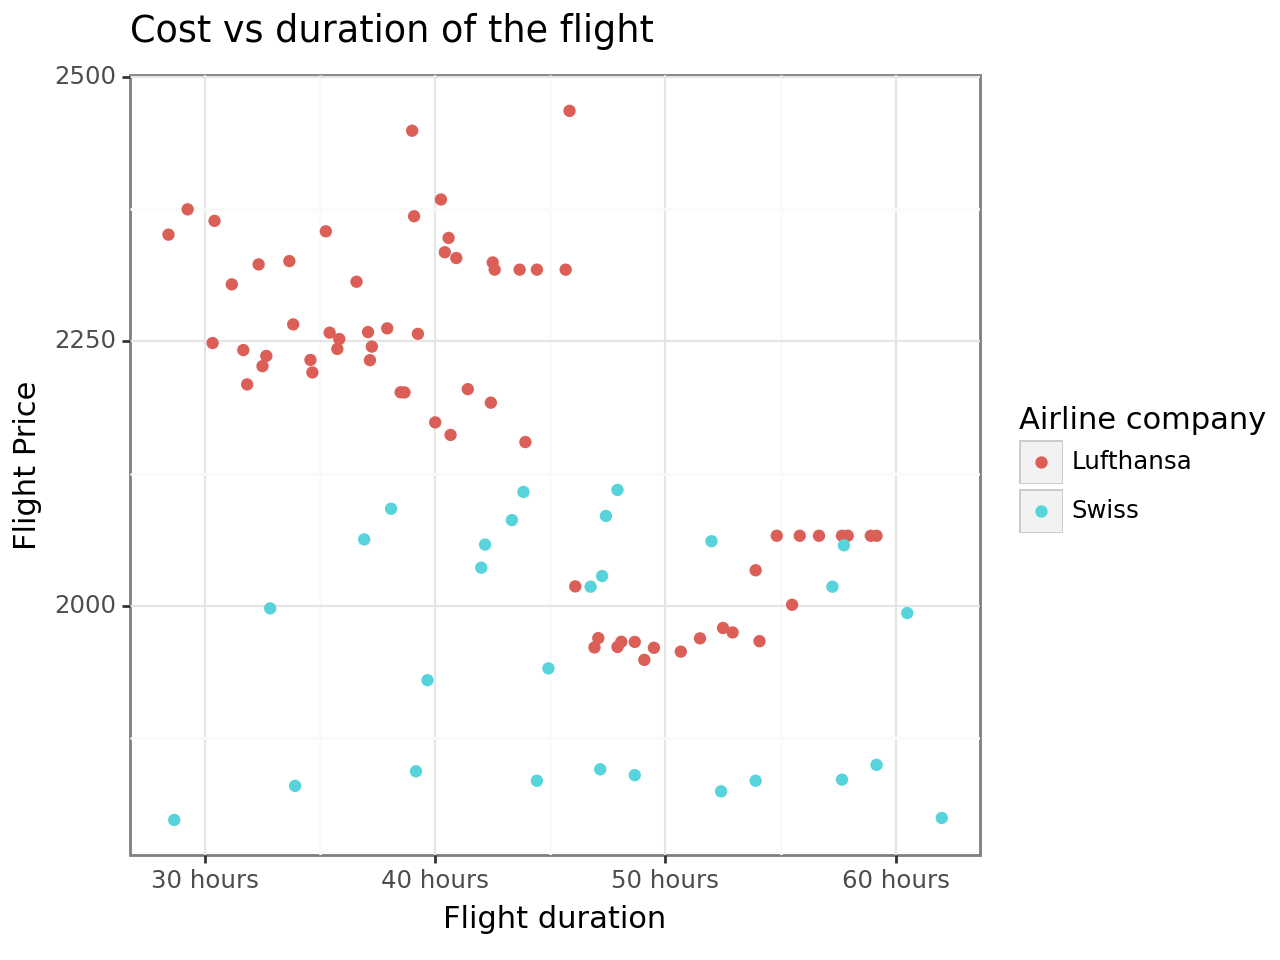

<Figure Size: (640 x 480)>

In [30]:
f7= (ggplot(scatterplot_sao, aes(x='tot_duration', y='price', color='out_airline_company')) + \
    geom_point() + \
    labs(title='Cost vs duration of the flight',
         x='Flight duration',
         y='Flight Price',
         color='Airline company') + \
    theme_bw()
)
f7

## Heatmap

In [31]:
heatmap = dataset[['ticket_price', 'tot_duration','out_dep_time','out_arr_time','in_dep_time','in_arr_time','date','out_stop_num','in_stop_num']]


heatmap['out_dep_time'] = pd.to_datetime(heatmap['out_dep_time'], format='%H:%M')
heatmap['out_arr_time'] = pd.to_datetime(heatmap['out_arr_time'], format='%H:%M')
heatmap['in_dep_time'] = pd.to_datetime(heatmap['out_arr_time'], format='%H:%M')
heatmap['in_arr_time'] = pd.to_datetime(heatmap['out_arr_time'], format='%H:%M')

heatmap

,ticket_price,tot_duration,out_dep_time,out_arr_time,in_dep_time,in_arr_time,date,out_stop_num,in_stop_num
0,1176.01,0 days 21:05:00,1900-01-01 09:35:00,1900-01-01 15:00:00,1900-01-01 15:00:00,1900-01-01 15:00:00,2023-05-20 16:00:00,1,1
1,923.39,1 days 05:10:00,1900-01-01 13:15:00,1900-01-01 20:05:00,1900-01-01 20:05:00,1900-01-01 20:05:00,2023-05-20 16:00:00,1,1
2,1176.01,0 days 21:50:00,1900-01-01 08:50:00,1900-01-01 15:00:00,1900-01-01 15:00:00,1900-01-01 15:00:00,2023-05-20 16:00:00,1,1
3,1176.01,0 days 22:05:00,1900-01-01 09:35:00,1900-01-01 15:00:00,1900-01-01 15:00:00,1900-01-01 15:00:00,2023-05-20 16:00:00,1,1
4,1176.01,0 days 22:15:00,1900-01-01 09:35:00,1900-01-01 15:00:00,1900-01-01 15:00:00,1900-01-01 15:00:00,2023-05-20 16:00:00,1,1
...,...,...,...,...,...,...,...,...,...
11243,2126.92,2 days 04:00:00,1900-01-01 15:00:00,1900-01-01 05:25:00,1900-01-01 05:25:00,1900-01-01 05:25:00,2023-05-31 12:00:00,2,2
11244,1976.92,2 days 09:45:00,1900-01-01 09:15:00,1900-01-01 05:25:00,1900-01-01 05:25:00,1900-01-01 05:25:00,2023-05-31 12:00:00,2,2
11245,1976.92,2 days 09:45:00,1900-01-01 09:15:00,1900-01-01 05:25:00,1900-01-01 05:25:00,1900-01-01 05:25:00,2023-05-31 12:00:00,2,2
11246,2100.92,2 days 09:15:00,1900-01-01 09:45:00,1900-01-01 05:25:00,1900-01-01 05:25:00,1900-01-01 05:25:00,2023-05-31 12:00:00,1,2


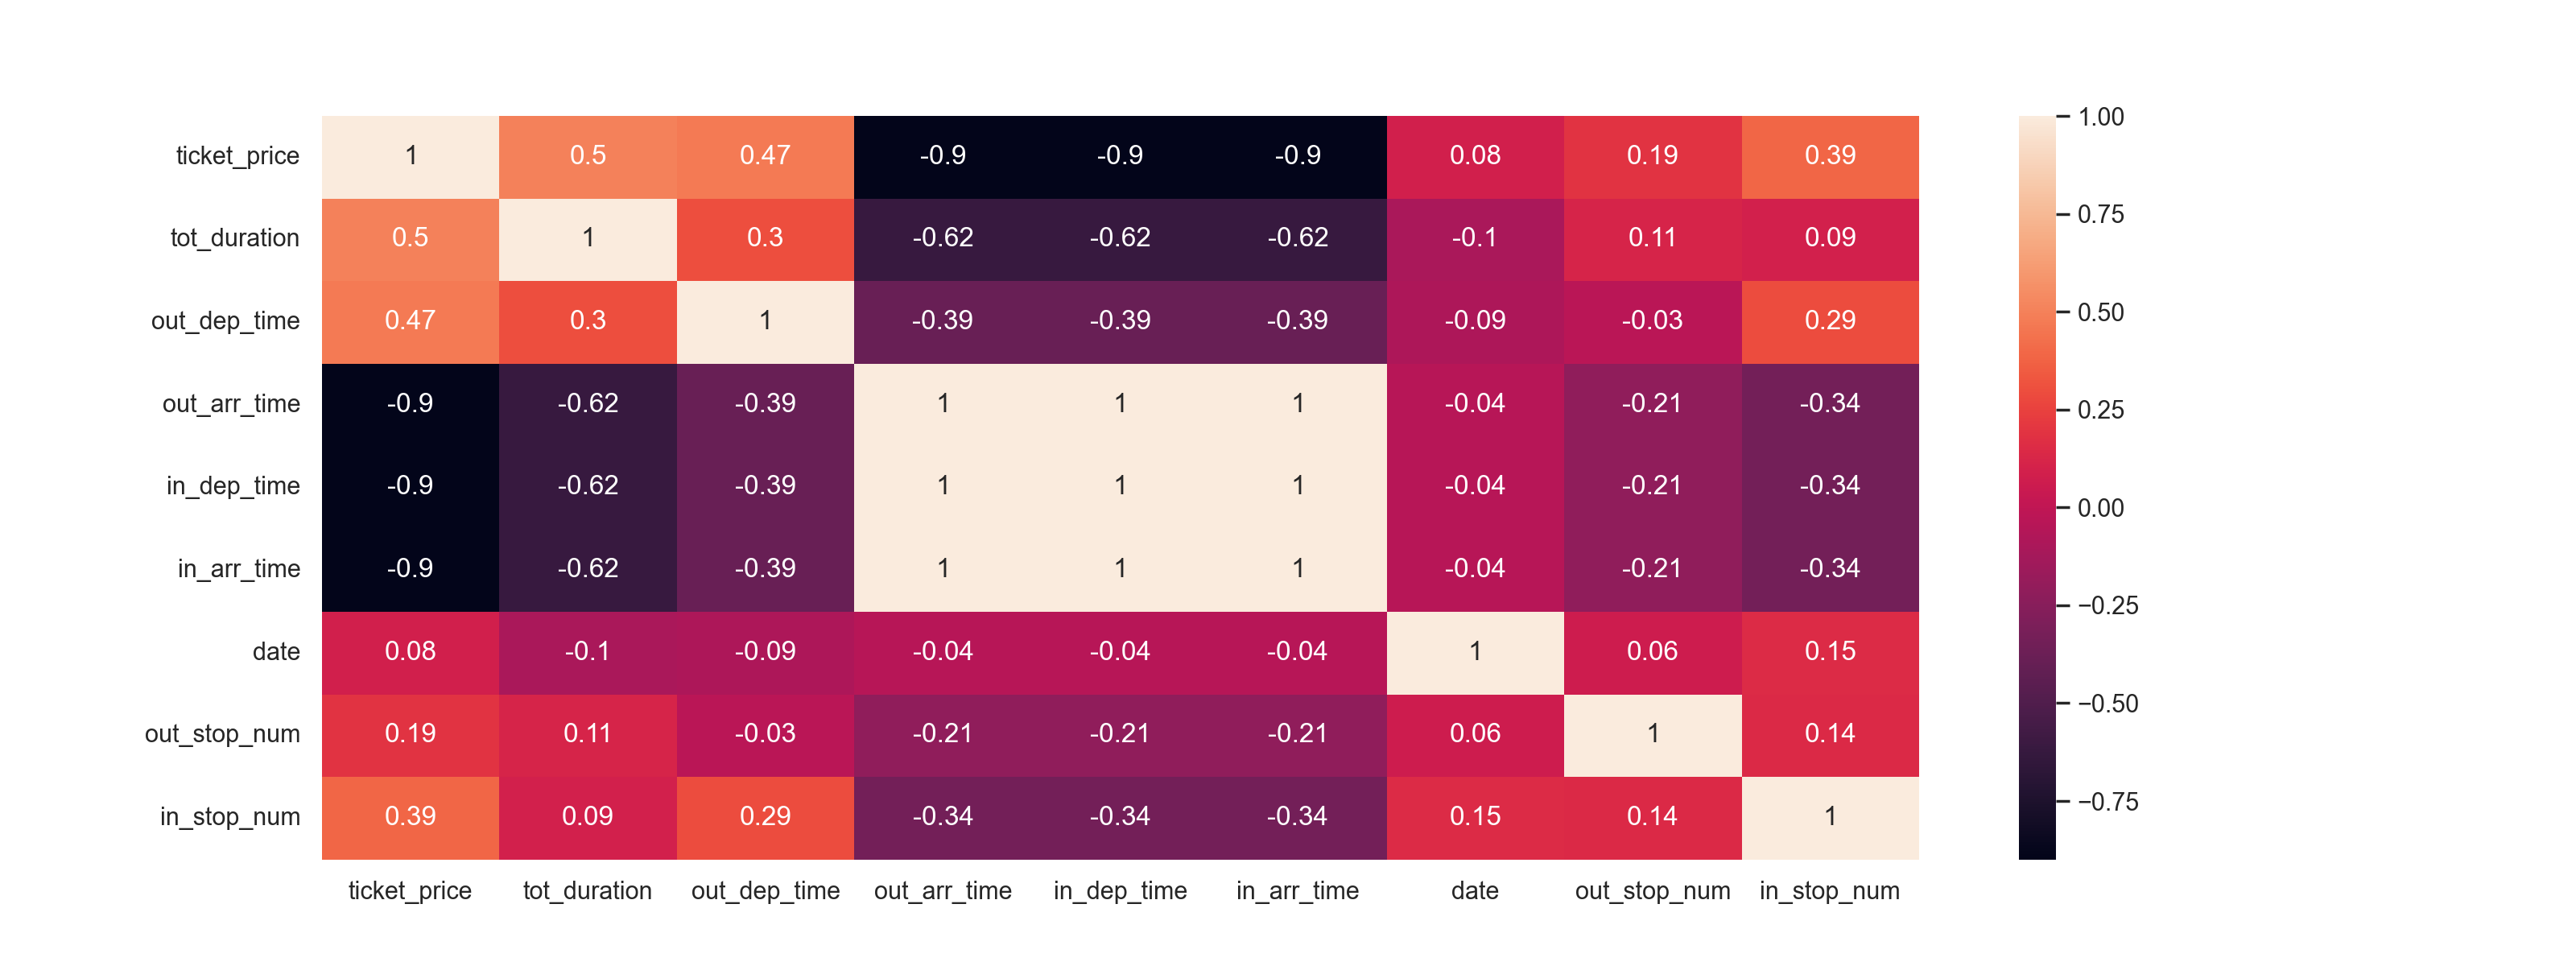

In [32]:
sns.set(rc={'figure.figsize':(16,6)})
correlation_matrix = heatmap.corr().round(2)
sns.heatmap(correlation_matrix, annot=True)
plt.show()